In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [2]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

In [3]:
train = train[train['임대건물구분']=='아파트']
test = test[test['임대건물구분']=='아파트']

In [4]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0

In [5]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0

In [6]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

In [7]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [8]:
not_unique = ['자격유형','임대보증금','임대료','전용면적별세대수','전용면적','공급유형']

tmp1 = train.drop(not_unique,axis=1).drop_duplicates()

tmp = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).sum()['전용면적별세대수']).reset_index()
tmp = pd.merge(tmp,tmp1.drop_duplicates(),on='단지코드',how='left')
total = pd.DataFrame(tmp.groupby('단지코드').sum()['전용면적별세대수']).reset_index(drop=False).rename(columns={'전용면적별세대수':'total'})
tmp = pd.merge(tmp,total,on='단지코드',how='left')
tmp['ratio'] = tmp.apply(lambda x : x['전용면적별세대수']/x['total'],axis=1)
tmp['y1'] = tmp.apply(lambda x : x['ratio']*x['등록차량수'],axis=1)

total = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).mean()['임대료']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

total = pd.DataFrame(train.groupby(['단지코드','전용면적','공급유형']).mean()['임대보증금']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

tmp['단지내주차면수_new'] = tmp.apply(lambda x : x['단지내주차면수']*x['ratio'],axis=1)
tmp = tmp.drop(['ratio'],axis=1)

train = tmp
train['y2'] = train.apply(lambda x : x['y1']/x['단지내주차면수_new'],axis=1)

In [9]:
tmp1 = test.drop(not_unique,axis=1).drop_duplicates()

tmp = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).sum()['전용면적별세대수']).reset_index()
tmp = pd.merge(tmp,tmp1.drop_duplicates(),on='단지코드',how='left')
total = pd.DataFrame(tmp.groupby('단지코드').sum()['전용면적별세대수']).reset_index(drop=False).rename(columns={'전용면적별세대수':'total'})
tmp = pd.merge(tmp,total,on='단지코드',how='left')
tmp['ratio'] = tmp.apply(lambda x : x['전용면적별세대수']/x['total'],axis=1)

total = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).mean()['임대료']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

total = pd.DataFrame(test.groupby(['단지코드','전용면적','공급유형']).mean()['임대보증금']).reset_index()
tmp = pd.merge(tmp,total,on=['단지코드','전용면적','공급유형'],how='left')

tmp['단지내주차면수_new'] = tmp.apply(lambda x : x['단지내주차면수']*x['ratio'],axis=1)
tmp = tmp.drop(['ratio'],axis=1)

test = tmp

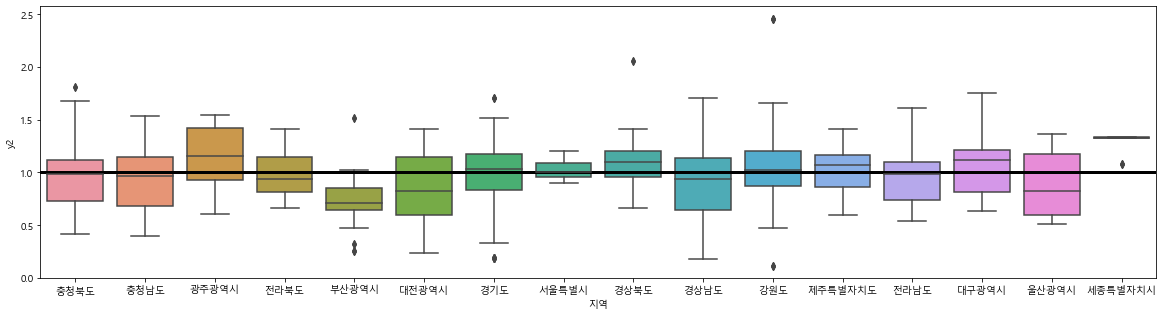

In [10]:
fig,ax = plt.subplots(figsize=(20,5))
sns.boxplot(x='지역',y='y2',data=train)
plt.axhline(1,linewidth='3',color='black')

- 경상남도의 경우 대부분 등록차량수/단지내주차면수가 1보다 작음 $\therefore$ 1보다 큰 단지코드의 경우 예측을 잘 못하는 경우가 발생
- 지역과 공급유형 별로 y2의 분포를 살펴보고 그룹핑을 함

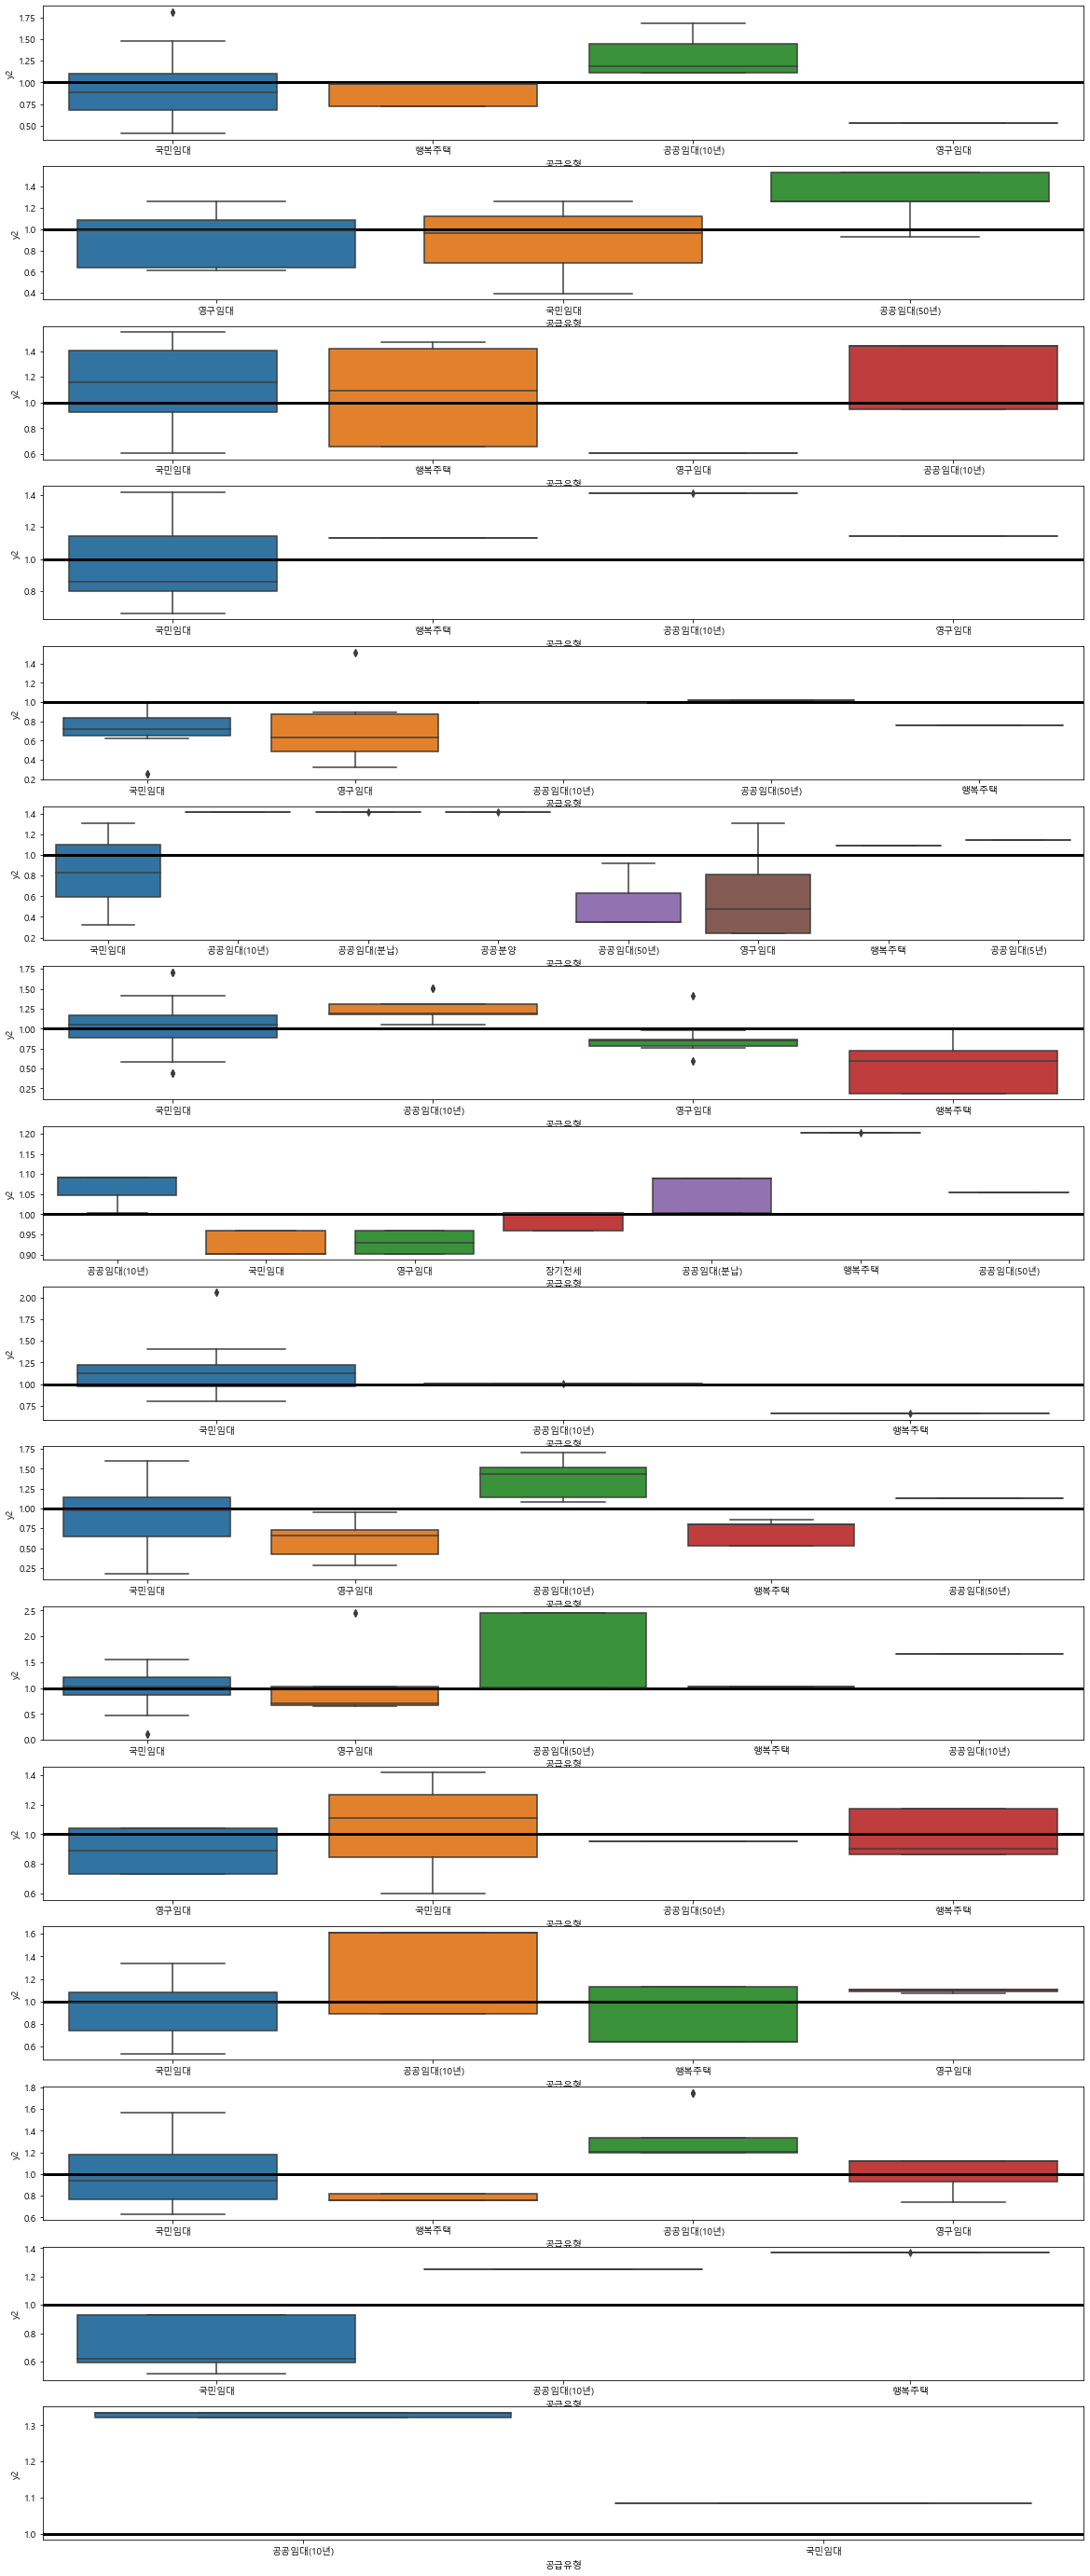

In [11]:
n = train['지역'].nunique()
fig,ax = plt.subplots(n,1,figsize=(20,50))
for ind,area in enumerate(train['지역'].unique()):
    sns.boxplot(x='공급유형',y='y2',data=train[train['지역']==area],ax=ax[ind])
    ax[ind].axhline(1,linewidth='3',color='black')

1보다 큰 지역

- 세종특별자치시
- 울산광역시 공공임대(10년)
- 대구광역시 공공임대(10년)
- 전라남도 영구임대 
- 전라남도 공공임대(10년)
- 강원도 공공임대(50년) 공공임대(10년) 행복주택 
- 경상남도 공공임대(50년)/공공임대(10년)
- 경상북도 국민임대 
- 서울특별시 
- 경기도 공공임대(10년)
- 대전광역시 공공임대(5년)/행복주택/공공분양/공공분양(분납)/공공임대(10년)
- 부산광역시 공공임대(50년)
- 전라북도 영구임대/공공임대(10년)/행복주택
- 충청남도 공공임대(50년)
- 충청북도 공공임대(50년)

1보다 작은 지역

- 울산광역시 국민임대
- 대구광역시 영구임대/행복주택
- 전라남도 행복주택 
- 강원도 영구임대 
- 경상남도 행복주택/ 영구임대
- 경상북도 행복주택 
- 경기도 행복주택/ 영구임대 
- 대전광역시 영구임대/공공임대(50년)
- 부산광역시 행복주택/영구임대/국민임대
- 광주광역시 영구임대
- 충청북도 영구임대/ 행복주택

In [12]:
train['cluster']  = 0

train.loc[train['지역'].isin(['세종특별자치시','서울특별시']),'cluster'] = 1

train.loc[(train['공급유형']=='국민임대')&(train['지역'].isin(['경상북도'])),'cluster'] = 1
train.loc[(train['공급유형']=='국민임대')&(train['지역'].isin(['울산광역시','부산광역시'])),'cluster'] = 2

train.loc[(train['공급유형']=='공공임대(50년)')&(train['지역'].isin(['강원도','경상남도','부산광역시','충청남도','충청북도'])),'cluster'] = 1
train.loc[(train['공급유형']=='공공임대(50년)')&(train['지역'].isin(['대전광역시'])),'cluster'] = 2

train.loc[(train['공급유형']=='영구임대')&(train['지역'].isin(['전라남도','전라북도'])),'cluster'] = 1
train.loc[(train['공급유형']=='영구임대')&(train['지역'].isin(['대전광역시','강원도','경상남도','경기도','대전광역시','부산광역시','광주광역시','충청북도'])),'cluster'] = 2

train.loc[(train['공급유형']=='공공임대(10년)'),'cluster'] = 1
train.loc[(train['공급유형']=='공공임대(분납)'),'cluster'] = 1
train.loc[(train['공급유형']=='공공분양'),'cluster'] = 1
train.loc[(train['공급유형']=='공공임대(5년)'),'cluster'] = 1

train.loc[(train['공급유형']=='행복주택')&(train['지역'].isin(['강원도','대전광역시','전라북도'])),'cluster'] = 1
train.loc[(train['공급유형']=='행복주택')&(train['지역'].isin(['대구광역시','전라남도','경상남도','경상북도','경기도','부산광역시','충청북도'])),'cluster'] = 2

train = train.join(pd.get_dummies(train['cluster'],prefix='cluster'))
train = train.drop(['cluster','cluster_0'],axis=1)

In [13]:
test['cluster']  = 0

test.loc[test['지역'].isin(['세종특별자치시','서울특별시']),'cluster'] = 1

test.loc[(test['공급유형']=='국민임대')&(test['지역'].isin(['경상북도'])),'cluster'] = 1
test.loc[(test['공급유형']=='국민임대')&(test['지역'].isin(['울산광역시','부산광역시'])),'cluster'] = 2

test.loc[(test['공급유형']=='공공임대(50년)')&(test['지역'].isin(['강원도','경상남도','부산광역시','충청남도','충청북도'])),'cluster'] = 1
test.loc[(test['공급유형']=='공공임대(50년)')&(test['지역'].isin(['대전광역시'])),'cluster'] = 2

test.loc[(test['공급유형']=='영구임대')&(test['지역'].isin(['전라남도','전라북도'])),'cluster'] = 1
test.loc[(test['공급유형']=='영구임대')&(test['지역'].isin(['대전광역시','강원도','경상남도','경기도','대전광역시','부산광역시','광주광역시','충청북도'])),'cluster'] = 2

test.loc[(test['공급유형']=='공공임대(10년)'),'cluster'] = 1
test.loc[(test['공급유형']=='공공임대(분납)'),'cluster'] = 1
test.loc[(test['공급유형']=='공공분양'),'cluster'] = 1
test.loc[(test['공급유형']=='공공임대(5년)'),'cluster'] = 1

test.loc[(test['공급유형']=='행복주택')&(test['지역'].isin(['강원도','대전광역시','전라북도'])),'cluster'] = 1
test.loc[(test['공급유형']=='행복주택')&(test['지역'].isin(['대구광역시','전라남도','경상남도','경상북도','경기도','부산광역시','충청북도'])),'cluster'] = 2

test = test.join(pd.get_dummies(test['cluster'],prefix='cluster'))
test = test.drop(['cluster','cluster_0'],axis=1)

In [14]:
def func(x):
    for i in range(10,90,10):
        if int(x) in range(i,i+10):
            return i+5

train['전용면적'] = train['전용면적'].apply(lambda x : func(x))
test['전용면적'] = test['전용면적'].apply(lambda x : func(x))

In [15]:
train = train.join(pd.get_dummies(train['공급유형']))
test = test.join(pd.get_dummies(test['공급유형']))
test['공공분양'] = 0
test['공공임대(5년)'] = 0 
test['장기전세'] = 0

In [16]:
train['0~19 인구수'] = train['0~19세_비율']*train['전용면적별세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['전용면적별세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['전용면적별세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['전용면적별세대수']

test['0~19 인구수'] = test['0~19세_비율']*test['전용면적별세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['전용면적별세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['전용면적별세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['전용면적별세대수']

col = ['0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율']
train = train.drop(col,axis=1)
test = test.drop(col,axis=1)

In [17]:
area_pop = pd.DataFrame(train.groupby('지역').mean()['총인구수']).reset_index().rename(columns={'총인구수':'지역인구수'})
train = pd.merge(train,area_pop,on='지역',how='left')
train['지역인구비율'] = train['총세대수']/train['지역인구수']
train = train.drop('지역인구수',axis=1)

test = pd.merge(test,area_pop,on='지역',how='left')
test['지역인구비율'] = test['총세대수']/test['지역인구수']
test = test.drop('지역인구수',axis=1)

In [18]:
tmp = train[['전용면적','전용면적별세대수']].pivot_table(index="전용면적",values="전용면적별세대수",aggfunc="max")
dic_tmp = dict(zip(list(tmp.index) ,list(tmp['전용면적별세대수'])))

train['전용면적별공가수'] = train['전용면적'].apply(lambda x: dic_tmp.get(x))-train['전용면적별세대수']
train['전용면적별공가비율'] = train['전용면적별공가수'] /train['전용면적'].apply(lambda x: dic_tmp.get(x))

test['전용면적별공가수'] = test['전용면적'].apply(lambda x: dic_tmp.get(x))-test['전용면적별세대수']
test['전용면적별공가비율'] = test['전용면적별공가수'] /test['전용면적'].apply(lambda x: dic_tmp.get(x))

In [19]:
train['세대당_가능주차면수new'] = train.apply(lambda x : x['단지내주차면수_new']/x['전용면적별세대수'],axis=1)
test['세대당_가능주차면수new'] = test.apply(lambda x : x['단지내주차면수_new']/x['전용면적별세대수'],axis=1)

train['ratio'] = train.apply(lambda x : x['전용면적별세대수']/x['총세대수'],axis=1)
test['ratio'] = test.apply(lambda x : x['전용면적별세대수']/x['총세대수'],axis=1)

In [20]:
train.corr()['y2']

전용면적             0.347605
전용면적별세대수        -0.123235
총세대수            -0.187096
공가수             -0.300563
지하철역            -0.080635
버스정류장            0.015537
단지내주차면수         -0.081009
등록차량수            0.380865
연면적             -0.011118
위도              -0.059636
경도               0.044270
subway_dist      0.029441
환승역 수           -0.054594
총인구수            -0.117923
세대당_인구           0.040458
남/여비율            0.025622
남/여_0~19세        0.011522
남/여_20~39세       0.021890
남/여_40~69세       0.000025
남/여_70세이상        0.005944
상가비율            -0.176893
공가비율            -0.098387
0~19 인구수        -0.103206
20~39 인구수       -0.118729
40~69 인구수       -0.123539
70세이상 인구수       -0.114296
total           -0.195718
y1               0.305189
임대료              0.301543
임대보증금            0.125837
단지내주차면수_new     -0.034359
y2               1.000000
cluster_1        0.345132
cluster_2       -0.369041
공공분양             0.071611
공공임대(10년)        0.306017
공공임대(50년)        0.069416
공공임대(5년)         0.023977
공공임대(분납)    

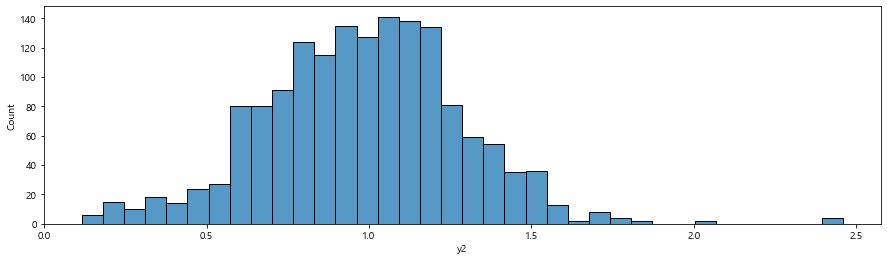

In [21]:
fig,ax = plt.subplots(figsize=(15,4))
sns.histplot(train['y2'])

In [22]:
train[train['y2']>2][['단지코드','y1','단지내주차면수_new','y2']] 

,단지코드,y1,단지내주차면수_new,y2
36,C1026,261.931034,127.241379,2.058537
37,C1026,160.068966,77.758621,2.058537
621,C1722,120.424658,48.986301,2.458333
622,C1722,120.424658,48.986301,2.458333
623,C1722,71.931507,29.260274,2.458333
624,C1722,336.219178,136.767123,2.458333


In [23]:
train = train[train['단지코드']!='C1722']
train = train.reset_index(drop=True)

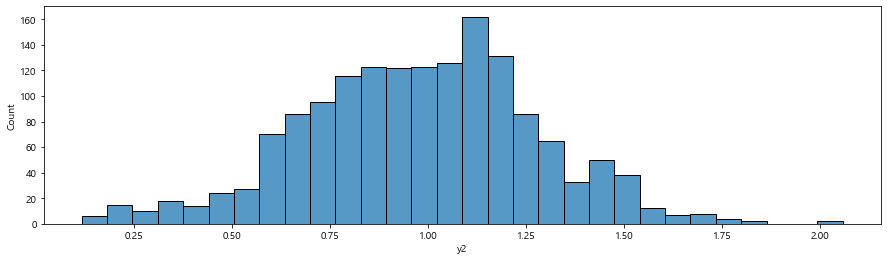

In [24]:
fig,ax = plt.subplots(figsize=(15,4))
sns.histplot(train['y2'])

In [25]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn import preprocessing

In [26]:
code = pd.DataFrame()
code['단지코드'] = train['단지코드'].unique()
code = code.reset_index()
train = pd.merge(train,code,on='단지코드') #80

In [27]:
model = [LinearRegression(), 
            PLSRegression(), 
            Ridge(random_state=2021),
            Lasso(random_state=2021), 
            ElasticNet(random_state=2021),
            SVR(),
            CatBoostRegressor(random_state=2021,loss_function='MAE',verbose=False),
            RandomForestRegressor(random_state=2021),
            GradientBoostingRegressor(random_state=2021)]
best = 100000
best_model = None


for j in model:
    s = 0
    print(j)
    for i in [80,160,240,320,400]:
        X = train[-train['index'].isin(range(i-80,i))]
        col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소','연면적','total','지역','단지내주차면수','y1','y2','위도','경도','공급유형','연면적','단지내주차면수_new','index']
        X_train = X.drop(col,axis=1)
        y_train = X['y2']
        X = train[train['index'].isin(range(i-80,i))]
        X_test = X.drop(col,axis=1)
        y_test = X['y2']

        cb = j.fit(X_train,y_train)
        pred = cb.predict(X_test)
        
        X['y2pred'] = pred
        X['y1pred'] = X['단지내주차면수_new']*X['y2pred']
        tmp1 = pd.DataFrame()
        tmp1['단지코드'] = X['단지코드'].unique()
        tmp1['y1'] = X.groupby(['단지코드']).sum()['y1'].tolist()
        tmp1['y1pred'] = X.groupby(['단지코드']).sum()['y1pred'].tolist()
        error = mean_absolute_error(tmp1['y1pred'],tmp1['y1'])
        print(error)
        s += error
    print('----done----')
    print(j,s/5)
    if s/5 < best:
        best_model = j
        best = s/5
print('----result----')
print(best_model,best)

LinearRegression()
147.48105026300004
115.08369436527062
161.76511150866455
96.27171839072545
113.22471906150425
----done----
LinearRegression() 126.76525871783299
PLSRegression()
148.1003875004119
115.13177223652642
109.50826679300135
101.14379819618946
106.25800310947125
----done----
PLSRegression() 116.02844556712007
Ridge(random_state=2021)
146.29521176184556
118.13256179708773
151.17883240072365
96.53212293618772
112.274502732938
----done----
Ridge(random_state=2021) 124.88264632575654
Lasso(random_state=2021)
158.57496409777326
124.41797610657348
126.38328952369554
104.0797916337586
119.19194801157087
----done----
Lasso(random_state=2021) 126.52959387467436
ElasticNet(random_state=2021)
158.1431710620513
124.42851814816011
124.57888215884361
103.88379160472257
120.0907414372493
----done----
ElasticNet(random_state=2021) 126.22502088220537
SVR()
165.92477862767763
138.05710535467057
124.80856236896707
114.46615741515161
139.17253112404507
----done----
SVR() 136.48582697810238
134.

In [28]:
code = train[-train['index'].isin(range(0,80))]['단지코드'].unique()

In [29]:
X = train[-train['index'].isin(range(0,80))]
col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소','연면적','total','지역','단지내주차면수','y1','y2','공급유형','연면적','단지내주차면수_new','index']
X_train = X.drop(col,axis=1)
y_train = X['y2']
X = train[train['index'].isin(range(0,80))]
X_test = X.drop(col,axis=1)
y_test = X['y2']

rf = RandomForestRegressor(random_state=2021).fit(X_train,y_train)
pred = rf.predict(X_test)

cb = CatBoostRegressor(random_state=2021,loss_function='MAE',verbose=False).fit(X_train,y_train)
pred2 = cb.predict(X_test)

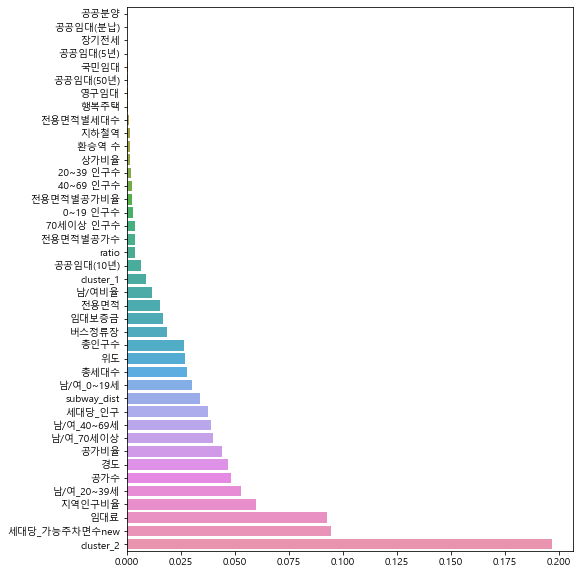

In [30]:
plt.figure(figsize=(8,10))
sns.barplot(y = X_test.columns[np.argsort(rf.feature_importances_)], x = list(rf.feature_importances_[np.argsort(rf.feature_importances_)]))

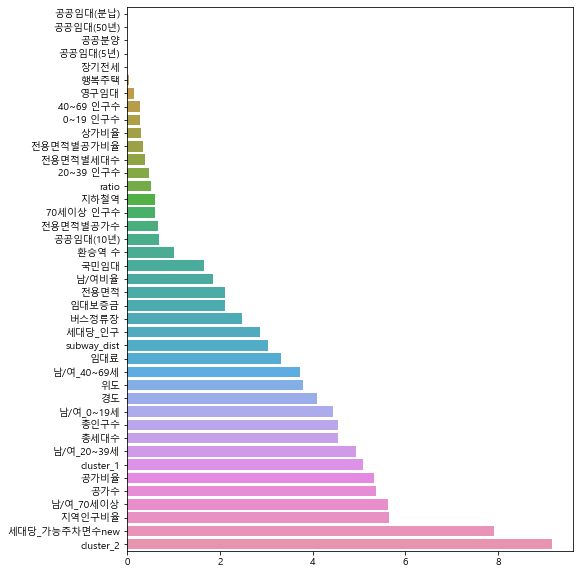

In [31]:
plt.figure(figsize=(8,10))
sns.barplot(y = X_test.columns[np.argsort(cb.feature_importances_)], x = list(cb.feature_importances_[np.argsort(cb.feature_importances_)]))

In [32]:
col = col = ['단지코드','등록차량수','임대건물구분','subway_name','단지명','도로명주소','연면적','total','지역','단지내주차면수','y1','y2','위도','경도','공급유형','연면적','단지내주차면수_new','index']
X_train = train.drop(col,axis=1)
y_train = train['y2']
col = ['단지코드','임대건물구분','subway_name','단지명','도로명주소','연면적','total','지역','단지내주차면수','위도','경도','공급유형','연면적','단지내주차면수_new']
X_test = test.drop(col,axis=1)

rf = RandomForestRegressor(random_state=2021).fit(X_train,y_train)
pred = rf.predict(X_test)

cb = CatBoostRegressor(random_state=2021,loss_function='MAE',verbose=False).fit(X_train,y_train)
pred2 = cb.predict(X_test)

In [33]:
test['y2pred_rf'] = pred
test['y1pred_rf'] = test['단지내주차면수_new']*test['y2pred_rf']
test['y2pred_cb'] = pred2
test['y1pred_cb'] = test['단지내주차면수_new']*test['y2pred_cb']
res = pd.DataFrame()
res['단지코드'] = test['단지코드'].unique()
res['rf'] = test.groupby(['단지코드']).sum()['y1pred_rf'].tolist()
res['cb'] = test.groupby(['단지코드']).sum()['y1pred_cb'].tolist()

In [34]:
submit = res[['단지코드','cb']]
submit.columns = ['code','num']
submit.loc[147,:] = ['C1327',0]
submit.loc[148,:] = ['C2335',0]
submit.loc[149,:] = ['C2675',0]

In [35]:
submit.to_csv("modeling2.csv",index=False)

In [36]:
res.head()

,단지코드,rf,cb
0,C1003,244.852372,264.176010
1,C1006,212.824717,244.523346
2,C1016,643.380133,646.750985
3,C1019,285.554542,301.837968
4,C1030,23.132132,23.359949
